# Trabalho 2 IART: Aprendizagem Supervisionada - Regressão
## Introdução
O futebol é possivelmente o desporto mais popular de sempre com milhões de adeptos e um igual número de jogadores dado ser talvez um dos desportos mais fáceis de jogar que existe.

Para além disso, este desporto movimenta uma grande quantidade de dinheiro quer pela venda de bilhetes e _merchandise_ quer pelas transferências de jogadores. Outro lado desta economia é o mercado das apostas desportivas que é cada vez mais procurado por adeptos. Sabe-se que os apostadores profissionais acertam na sua aposta cerca de 53% das vezes.

Sendo assim, o objetivo deste trabalho é prever o resultado de jogos de maneira a criar um sistema que recomenda o resultado do jogo em que apostar, preferivelmente com uma precisão superior à dos apostadores profissionais.

## Descrição do _dataset_
O _dataset_ inclui informação acerca de 25000 partidas de futebol em ligas de 11 países europeus realizadas nas épocas de 2008 a 2016 e acerca de 10000 jogadores. Este inclui ainda informação sobre os _odds_ fornecidos por vários _sites_ de apostas para os vários jogos.
Mais informação pode ser encontrada [aqui](https://www.kaggle.com/hugomathien/soccer).

## Aquisição e exploração de dados
O _dataset_ que irá ser usado corresponde a uma base de dados sqlite que inclui as tabelas a seguir apresentadas e que contêm a seguinte informação:

In [2]:
import sqlite3

conn = sqlite3.connect('soccer.db')
cursor = conn.cursor()
cursor.execute("select name from sqlite_master where type='table'; ")
cursor.fetchall()

[('sqlite_sequence',),
 ('Player_Attributes',),
 ('Player',),
 ('Match',),
 ('League',),
 ('Country',),
 ('Team',),
 ('Team_Attributes',)]

* **Country:**  Países para os quais existe informação.
* **League:** Ligas de futebol dos vários países incluídos na tabela _Country_.
* **Match:** Informação sobre as várias partidas de futebol que inclui estatísticas do jogo, _odds_, bem como os jogadores que participaram.
* **Player:** Informação sobre os vários jogadores da base de dados, incluindo nome, data de nascimento, altura e peso.
* **Player_Attributes:** Habilidades de cada um dos jogadores tiradas do jogo FIFA.
* **Team:** Informação acerca de cada uma das equipas, incluindo o seu nome.
* **Team_Attributes:** Habilidades de cada uma das equipas tiradas do jogo FIFA.

Dado tratar-se de um _dataset_ extenso (~300MB) apenas serão consideradas partidas jogadas na English Premier League, já que corresponde a uma liga com um número razoável de equipas e jogos. Sendo assim, os passos seguintes têm como objetivo extrair informação acerca desta liga.

In [174]:
import pandas as pd
from lxml import etree as et

matches = pd.read_sql_query("select Match.id, League.name, Match.season, Match.possession, T1.team_long_name as home_team, Match.home_team_goal, T2.team_long_name as away_team, away_team_goal, stage, date, B365H, B365D, B365A from League, Match on (League.id = Match.league_id), Team as T1 on (T1.team_api_id = Match.home_team_api_id), Team as T2 on (T2.team_api_id = Match.away_team_api_id) where League.name = 'England Premier League'", conn)
matches.head()


# Get possession XML data
matches['possession'] = matches['possession'].apply(lambda x: et.fromstring(x))

possession = et.Element("possession")

for id,row in zip(matches['id'],matches['possession']):
    #print(et.tostring(row, pretty_print=True).decode())
    if(len(row.getchildren())):
        match = et.SubElement(possession,'match')
        match.set('id', str(id))
        for child in row[-1].getchildren():
            el = et.fromstring(et.tostring(child))
            match.append(el)

file = open('xml/possession.xml', 'w+')
file.write(et.tostring(possession, pretty_print=True).decode())

for _, element in et.iterparse("xml/possession.xml", tag='match'):
    print('Match_id: ' + element.get('id'))
    print('HOME_POS: %s -- AWAY_POS: %s\n' % (element.findtext('homepos'), element.findtext('awaypos')))
    element.clear(keep_tail=True)

Match_id: 1729
HOME_POS: 55 -- AWAY_POS: 45

Match_id: 1730
HOME_POS: 66 -- AWAY_POS: 34

Match_id: 1731
HOME_POS: 46 -- AWAY_POS: 54

Match_id: 1732
HOME_POS: 52 -- AWAY_POS: 48

Match_id: 1733
HOME_POS: 52 -- AWAY_POS: 48

Match_id: 1734
HOME_POS: 51 -- AWAY_POS: 49

Match_id: 1735
HOME_POS: 53 -- AWAY_POS: 47

Match_id: 1736
HOME_POS: 47 -- AWAY_POS: 53

Match_id: 1737
HOME_POS: 53 -- AWAY_POS: 47

Match_id: 1738
HOME_POS: 65 -- AWAY_POS: 35

Match_id: 1739
HOME_POS: 60 -- AWAY_POS: 40

Match_id: 1740
HOME_POS: 62 -- AWAY_POS: 38

Match_id: 1741
HOME_POS: 45 -- AWAY_POS: 55

Match_id: 1742
HOME_POS: 53 -- AWAY_POS: 47

Match_id: 1744
HOME_POS: 52 -- AWAY_POS: 48

Match_id: 1745
HOME_POS: 54 -- AWAY_POS: 46

Match_id: 1746
HOME_POS: 57 -- AWAY_POS: 43

Match_id: 1747
HOME_POS: 51 -- AWAY_POS: 49

Match_id: 1748
HOME_POS: 50 -- AWAY_POS: 50

Match_id: 1749
HOME_POS: 51 -- AWAY_POS: 49

Match_id: 1750
HOME_POS: 49 -- AWAY_POS: 51

Match_id: 1751
HOME_POS: 54 -- AWAY_POS: 46

Match_id: 

Vamos agora criar três novas colunas que representam para cada jogo o lado vencedor (equipa da casa ou equipa de fora) ou empate.

In [5]:
matches = matches.assign(home_win=lambda matches: matches.apply(lambda row: 1 if row.home_team_goal > row.away_team_goal else 0, axis='columns'),
              draw=lambda matches: matches.apply(lambda row: 1 if row.home_team_goal == row.away_team_goal else 0, axis='columns'),
              away_win=lambda matches: matches.apply(lambda row: 1 if row.home_team_goal < row.away_team_goal else 0, axis='columns'))

Podemos agora calcular a taxa de vitórias, empates e derrotas em relação à equipa que joga em casa.

In [6]:
win_rates = matches.groupby('season') \
                   .mean() \
                   .loc[:, ['home_win', 'draw', 'away_win']]
win_rates

,home_win,draw,away_win
season,,,
2008/2009,0.455263,0.255263,0.289474
2009/2010,0.507895,0.252632,0.239474
2010/2011,0.471053,0.292105,0.236842
2011/2012,0.450000,0.244737,0.305263
2012/2013,0.436842,0.284211,0.278947
2013/2014,0.471053,0.205263,0.323684
2014/2015,0.452632,0.244737,0.302632
2015/2016,0.413158,0.281579,0.305263


Com estes dados podemos concluir que as equipas que jogam em casa têm uma maior possibilidade de vencer a partida.
Cerca de 46% dos jogos acabam com a vitória da equipa da casa, 28% acabam com vitória da equipa de fora e o acontecimento menos comum é o empate que ocorre em 26% dos jogos. Apresenta-se agora um gráfico com a evolução das taxas em estudo:

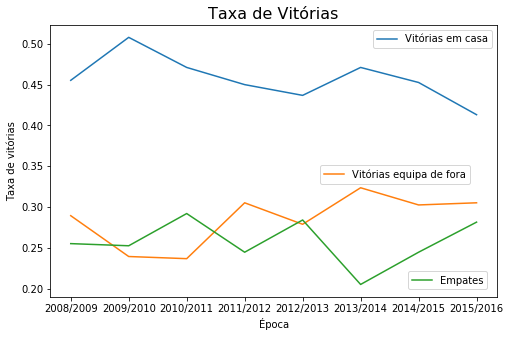

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)


home_line = ax.plot(win_rates.home_win, label='Vitórias em casa')
away_line = ax.plot(win_rates.away_win, label='Vitórias equipa de fora')
draw_line = ax.plot(win_rates.draw, label='Empates')
ax.set_xlabel("Época")
ax.set_ylabel("Taxa de vitórias")
plt.title("Taxa de Vitórias", fontsize=16)

# Add the legend locations
home_legend = plt.legend(handles=home_line, loc='upper right', bbox_to_anchor=(1, 1))
ax = plt.gca().add_artist(home_legend)
away_legend = plt.legend(handles=away_line, loc='center right', bbox_to_anchor=(0.95, 0.45))
ax = plt.gca().add_artist(away_legend)
draw_legend = plt.legend(handles=draw_line, loc='center right', bbox_to_anchor=(0.99, 0.06))

Podemos observar no gráfico que cada vez é mais difícil ter uma vitória em casa, parecendo ser cada vez mais provável haver um empate.

Uma medida interessante é quão vantajoso é para uma equipa, jogar em casa (HGA ou *Home Ground Advantage*) definido como a diferença entre a probabilidade da equipa ganhar em casa e a de ganhar fora.

In [8]:
home_win_rates = matches.groupby(['home_team']) \
                   .home_win \
                   .mean()

away_win_rates = matches.groupby(['away_team']) \
                   .away_win \
                   .mean()

hga = (home_win_rates - away_win_rates).reset_index().rename(columns={0: 'HGA'}).sort_values(by='HGA', ascending=False)
hga.head()

,home_team,HGA
16,Manchester City,0.335526
12,Fulham,0.289474
17,Manchester United,0.263158
25,Stoke City,0.263158
21,Portsmouth,0.236842


Mais interessante ainda é a variação desta medida ao longo do tempo para os vários clubes.

In [9]:
big_clubs = ['Liverpool', 'Manchester City', 'Manchester United', 'Chelsea', 'Arsenal']
home_win_rates_5 = matches[matches.home_team.isin(big_clubs)].groupby(['home_team', 'season']).home_win.mean()
away_win_rates_5 = matches[matches.away_team.isin(big_clubs)].groupby(['away_team', 'season']).away_win.mean()

hga_top_5 = home_win_rates_5 - away_win_rates_5

hga_top_5.unstack(level=0)

home_team,Arsenal,Chelsea,Liverpool,Manchester City,Manchester United
season,,,,,
2008/2009,0.105263,-0.157895,-0.052632,0.578947,0.210526
2009/2010,0.368421,0.368421,0.421053,0.315789,0.263158
2010/2011,0.157895,0.368421,0.368421,0.263158,0.684211
2011/2012,0.157895,0.315789,-0.105263,0.421053,0.105263
2012/2013,0.052632,0.105263,0.105263,0.263158,0.210526
2013/2014,0.105263,0.263158,0.315789,0.368421,-0.052632
2014/2015,0.105263,0.210526,0.105263,0.210526,0.421053
2015/2016,0.210526,-0.105263,0.000000,0.263158,0.263158


Apresenta-se a seguir um gráfico que representa a tabela acima.

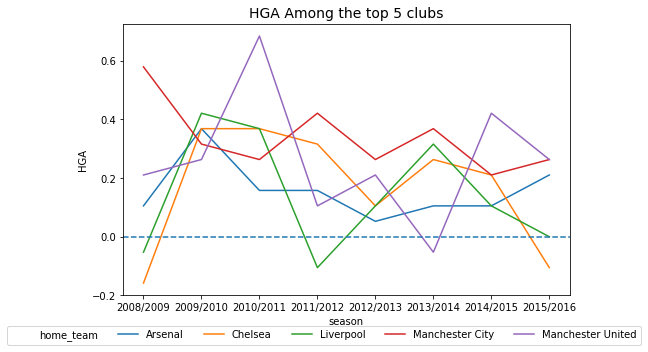

In [10]:
import seaborn as sns

plt.figure(figsize=(8, 5))
plot = sns.lineplot(x='season', y='HGA', hue='home_team', data=hga_top_5.reset_index().rename(columns={0: 'HGA', 'home_team': 'home_team'}))
plt.legend(loc='lower center', ncol=6, bbox_to_anchor=(0.45, -0.2))
plt.title("HGA Among the top 5 clubs", fontsize=14)

plot.axes.axhline(0, ls='--')

plt.show()

Os resultados são erráticos mas há duas equipas que têm esta medida sempre positiva (Arsenal e Manchester City). Interessantemente, algumas equipas, em algumas épocas ganharam mais jogos fora de casa do que em casa.

## Preparação dos Dados

O objetivo desta fase é preparar os dados para o processo de modelação e treino do modelo.

Para isto, é necessário alterar o formato dos dados já que é preferível que os dados relativos a cada uma das equipas estejam cada um na sua linha para serem tratados pelos algoritmos de Machine Learning. Por outro lado, é preferível calcular os dados relativos a cada uma das equipas com as equipas em linhas separadas.

In [11]:
stats = matches \
        .assign(date=lambda df: pd.to_datetime(df.date)) \
        .pipe(lambda df: df.dropna(thresh=len(df) - 2, axis=1)) \
        .dropna(axis=0) \
        .sort_values('date') \
        .reset_index(drop=True) \
        .assign(gameId=lambda df: list(df.index + 1))

stats_cols = ['gameId', 'home_team', 'away_team', 'home_team_goal', 'away_team_goal']

stats = stats[stats_cols].copy()
stats.head()

,gameId,home_team,away_team,home_team_goal,away_team_goal
0,1,Arsenal,West Bromwich Albion,1,0
1,2,Sunderland,Liverpool,0,1
2,3,West Ham United,Wigan Athletic,2,1
3,4,Everton,Blackburn Rovers,2,3
4,5,Middlesbrough,Tottenham Hotspur,2,1


In [12]:
betting = matches \
            .assign(date=lambda df: pd.to_datetime(df.date)) \
            .pipe(lambda df: df.dropna(thresh=len(df) - 2, axis=1)) \
            .dropna(axis=0) \
            .sort_values('date') \
            .reset_index(drop=True) \
            .assign(gameId=lambda df: list(df.index + 1), 
                    year=lambda df: df.date.apply(lambda row: row.year), 
                    home_win=lambda df: df.apply(lambda row: 1 if row.home_team_goal > row.away_team_goal else 0, axis=1),
                    away_win=lambda df: df.apply(lambda row: 1 if row.away_team_goal > row.home_team_goal else 0, axis=1),
                    result=lambda df: df.apply(
                            lambda row: 'home' if row.home_team_goal > row.away_team_goal else ('draw' if row.home_team_goal == row.away_team_goal else 'away'), axis=1))

betting_cols = ['B365A', 'B365D', 'B365H', 'home_win', 'away_win', 'result', 'home_team', 'away_team', 'gameId']

betting = betting[betting_cols].copy()
betting.head()

,B365A,B365D,B365H,home_win,away_win,result,home_team,away_team,gameId
0,15.00,6.5,1.20,1,0,home,Arsenal,West Bromwich Albion,1
1,1.67,3.6,5.50,0,1,away,Sunderland,Liverpool,2
2,4.20,3.4,1.91,1,0,home,West Ham United,Wigan Athletic,3
3,4.00,3.3,2.00,0,1,away,Everton,Blackburn Rovers,4
4,2.25,3.4,3.20,1,0,home,Middlesbrough,Tottenham Hotspur,5


In [51]:
# Probably useless
team_info = matches \
            .assign(date=lambda df: pd.to_datetime(df.date)) \
            .pipe(lambda df: df.dropna(thresh=len(df) - 2, axis=1)) \
            .dropna(axis=0) \
            .sort_values('date') \
            .reset_index(drop=True) \
            .assign(gameId=lambda df: list(df.index + 1), 
                    year=lambda df: df.date.apply(lambda row: row.year), 
                    home_win=lambda df: df.apply(lambda row: 1 if row.home_team_goal > row.away_team_goal else 0, axis=1),
                    away_win=lambda df: df.apply(lambda row: 1 if row.away_team_goal > row.home_team_goal else 0, axis=1),
                    result=lambda df: df.apply(
                            lambda row: 'home' if row.home_team_goal > row.away_team_goal else ('draw' if row.home_team_goal == row.away_team_goal else 'away'), axis=1))

team_info = team_info[['gameId', 'date', 'season', 'home_team', 'away_team']].copy()
team_info.head()

,gameId,date,season,home_team,away_team
0,1,2008-08-16,2008/2009,Arsenal,West Bromwich Albion
1,2,2008-08-16,2008/2009,Sunderland,Liverpool
2,3,2008-08-16,2008/2009,West Ham United,Wigan Athletic
3,4,2008-08-16,2008/2009,Everton,Blackburn Rovers
4,5,2008-08-16,2008/2009,Middlesbrough,Tottenham Hotspur


In [13]:
historic_games = matches \
                .assign(date=lambda df: pd.to_datetime(df.date),
                        gameId=-1,
                        homeWin=lambda df: df.apply(lambda row: 1 if row.home_team_goal > row.away_team_goal else 0, axis='columns'))
historic_games.head()

,name,season,possession,home_team,home_team_goal,away_team,away_team_goal,stage,date,B365H,B365D,B365A,home_win,draw,away_win,gameId,homeWin
0,England Premier League,2008/2009,"[[[], [], [], [], [], [], [], [], [], []], [[]...",Manchester United,1,Newcastle United,1,1,2008-08-17,1.29,5.5,11.00,0,1,0,-1,0
1,England Premier League,2008/2009,"[[[], [], [], [], [], [], [], [], [], []], [[]...",Arsenal,1,West Bromwich Albion,0,1,2008-08-16,1.20,6.5,15.00,1,0,0,-1,1
2,England Premier League,2008/2009,"[[[], [], [], [], [], [], [], [], [], []], [[]...",Sunderland,0,Liverpool,1,1,2008-08-16,5.50,3.6,1.67,0,0,1,-1,0
3,England Premier League,2008/2009,"[[[], [], [], [], [], [], [], [], [], []], [[]...",West Ham United,2,Wigan Athletic,1,1,2008-08-16,1.91,3.4,4.20,1,0,0,-1,1
4,England Premier League,2008/2009,"[[[], [], [], [], [], [], [], [], [], []], [[]...",Aston Villa,4,Manchester City,2,1,2008-08-17,1.91,3.4,4.33,1,0,0,-1,1


### Criação de features

TODO: escrever qualquer coisa

In [18]:
# Define a function which restructures our DataFrame
def create_multiline_df_stats(old_stats_df):
    # Create a list of columns we want and their mappings to more interpretable names
    home_stats_cols = ['home_team', 'home_team_goal', 'away_team_goal']
    
    away_stats_cols = ['away_team', 'home_team_goal', 'away_team_goal']
    
    stats_cols_mapping = ['team', 'goals_for', 'goals_against']
    
    # Create a dictionary of the old column names to new column names
    home_mapping = {old_col: new_col for old_col, new_col in zip(home_stats_cols, stats_cols_mapping)}
    away_mapping = {old_col: new_col for old_col, new_col in zip(away_stats_cols, stats_cols_mapping)}
    
    # Put each team onto an individual row
    multi_line_stats = old_stats_df[['gameId'] + home_stats_cols] \
                        .rename(columns=home_mapping) \
                        .assign(home_game=1) \
                        .append((old_stats_df[['gameId'] + away_stats_cols]) \
                                .rename(columns=away_mapping) \
                                .assign(home_game=0), sort=True) \
                        .sort_values(by='gameId') \
                        .reset_index(drop=True)
    return multi_line_stats

In [22]:
# Define a function which creates an EMA DataFrame from the stats DataFrame
def create_stats_features_ema(stats, span):
    # Create a restructured DataFrames so that we can calculate EMA
    multi_line_stats = create_multiline_df_stats(stats)
    
    # Create a copy of the DataFrame
    ema_features = multi_line_stats[['gameId', 'team', 'home_game']].copy()
    
    # Get the columns that we want to create EMA for
    feature_names = multi_line_stats.drop(columns=['gameId', 'team', 'home_game']).columns
    
    # Loop over the features
    for feature_name in feature_names:
        feature_ema = (multi_line_stats.groupby('team')[feature_name] # Calculate the EMA
                                                  .transform(lambda row: row.ewm(span=span, min_periods=2)
                                                             .mean()
                                                             .shift(1))) # Shift the data down 1 so we don't leak data
        ema_features[feature_name] = feature_ema # Add the new feature to the DataFrame
    return ema_features

# Apply the function
stats_features = create_stats_features_ema(stats, span=5)
stats_features.tail()

,gameId,team,home_game,goals_against,goals_for
6075,3038,Watford,1,1.234010,2.719517
6076,3039,Aston Villa,0,1.439889,1.240874
6077,3039,Arsenal,1,0.970182,1.464095
6078,3040,Manchester United,1,1.078647,1.629736
6079,3040,Bournemouth,0,1.754270,1.277571


In [23]:
pd.DataFrame(stats_features.groupby('team')
                           .goals_for
                           .mean()
                           .sort_values(ascending=False)[:10])

,goals_for
team,
Blackpool,1.850836
Manchester City,1.798916
Blackburn Rovers,1.711104
Burnley,1.678766
Reading,1.660961
Arsenal,1.650584
Norwich City,1.640411
Newcastle United,1.638319
Liverpool,1.633863


### Otimizar o Alpha

In [24]:
def restructure_stats_features(stats_features):
    non_features = ['home_game', 'team', 'gameId']

    stats_features_restructured = (stats_features.query('home_game == 1')
                                    .rename(columns={col: 'f_' + col + 'Home' for col in stats_features.columns if col not in non_features})
                                    .rename(columns={'team': 'home_team'})
                                    .pipe(pd.merge, (stats_features.query('home_game == 0')
                                                        .rename(columns={'team': 'away_team'})
                                                        .rename(columns={col: 'f_' + col + 'Away' for col in stats_features.columns 
                                                                         if col not in non_features})), on=['gameId'])
                                    .pipe(pd.merge, betting[['gameId', 'result']], on='gameId')
                                    .dropna())
    return stats_features_restructured

restructure_stats_features(stats_features).head()

,gameId,home_team,home_game_x,f_goals_againstHome,f_goals_forHome,away_team,home_game_y,f_goals_againstAway,f_goals_forAway,result
20,21,Arsenal,1,0.0,1.0,Newcastle United,0,0.4,1.0,home
21,22,Hull City,1,1.0,1.4,Wigan Athletic,0,1.0,0.8,away
22,23,Bolton Wanderers,1,0.4,1.8,West Bromwich Albion,0,1.2,1.0,draw
23,24,Middlesbrough,1,1.0,2.0,Stoke City,0,1.6,3.0,home
24,25,Everton,1,2.4,1.4,Portsmouth,0,0.6,1.6,away


In [25]:
def optimise_alpha(features):
    le = LabelEncoder()
    y = le.fit_transform(features.result) # Encode the result from away, draw, home win to 0, 1, 2
    X = features[[col for col in features.columns if col.startswith('f_')]] # Only get the features - these all start with f_
    lr = LogisticRegression()
    
    kfold = StratifiedKFold(n_splits=5)
    ave_cv_score = cross_val_score(lr, X, y, scoring='neg_log_loss', cv=kfold).mean()
    return ave_cv_score

In [26]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score

best_score = np.float('inf')
best_span = 0
cv_scores = []

# Iterate over a range of spans
for span in range(1, 100, 3):
    stats_features = create_stats_features_ema(stats, span=span)
    restructured_stats_features = restructure_stats_features(stats_features)
    cv_score = optimise_alpha(restructured_stats_features)
    cv_scores.append(cv_score)
    
    if cv_score * -1 < best_score:
        best_score = cv_score * -1
        best_span = span

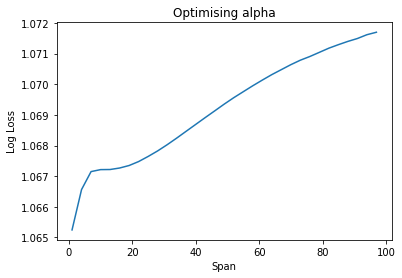

Our lowest log loss (1.065247) occurred at a span of 1


In [27]:
# There must be a problem here, lowest log loss is at a span of 1
plt.plot(list(range(1, 100, 3)), (pd.Series(cv_scores)*-1)) # Plot our results

plt.title("Optimising alpha")
plt.xlabel("Span")
plt.ylabel("Log Loss")
plt.show()

print("Our lowest log loss ({:2f}) occurred at a span of {}".format(best_score, best_span))

In [29]:
features_stats = create_stats_features_ema(stats, span=best_span)
features_stats.tail(3)

,gameId,team,home_game,goals_against,goals_for
6077,3039,Arsenal,1,2.0,2.0
6078,3040,Manchester United,1,2.0,3.0
6079,3040,Bournemouth,0,1.0,1.0


In [30]:
def create_multiline_df_betting(betting):
    multi_line_odds = betting[['gameId', 'home_team']] \
                      .rename(columns={'home_team': 'team'}) \
                      .append(betting[['gameId', 'away_team']]) \
                      .rename(columns={'away_team': 'team'}) \
                      .sort_values(by='gameId')\
                      .reset_index(drop=True)
    return multi_line_odds

def create_betting_features_ema(betting, span):
    multi_line_odds = create_multiline_df_betting(betting)
    
    ema_features = multi_line_odds[['gameId', 'team']].copy()

    feature_names = multi_line_odds.drop(columns=['gameId', 'team']).columns

    for feature_name in feature_names:
        feature_ema = (multi_line_odds.groupby('team')[feature_name]
                                      .transform(lambda row: row.ewm(span=span, min_periods=2)
                                      .mean()
                                      .shift(1)))

        ema_features[feature_name] = feature_ema
        
    return ema_features

# Create feature_odds df
features_odds = create_betting_features_ema(betting, span=10)
features_odds.tail(3)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,gameId,team,team
6077,3039,NaN,Arsenal
6078,3040,NaN,Manchester United
6079,3040,Bournemouth,NaN


# Escolher os algoritmos

Para analisarmos os dados escolhemos os algoritmos Logistic Regression, K-Nearest-Neighbours e Support Vector Machines pois são os mais adequados para os dados que temos. 

In [31]:
def create_feature_df(df=None):
    ##########################
    ## Create segmented dfs ##
    ##########################
    
    if df is None:
        df = create_df('data/epl_data.csv')

    stats_cols = ['gameId', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'HTHG', 'HTAG', 'HS', 'AS', 
                                'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']

    betting_cols = ['B365A', 'B365D', 'B365H', 'BWA', 'BWD', 'BWH', 'Bb1X2', 'BbAH', 'BbAHh', 'BbAv<2.5', 
                            'BbAv>2.5', 'BbAvA', 'BbAvAHA', 'BbAvAHH', 'BbAvD', 'BbAvH', 'BbMx<2.5', 'BbMx>2.5', 
                            'BbMxA', 'BbMxAHA', 'BbMxAHH', 'BbMxD', 'BbMxH', 'BbOU', 'Day', 'Div', 'IWA', 'IWD', 
                            'IWH', 'LBA', 'LBD', 'LBH', 'Month', 'VCA', 'VCD', 'VCH', 'Year', 
                            'homeWin', 'awayWin', 'result', 'HomeTeam', 'AwayTeam', 'gameId']
    betting_cols = [col for col in betting_cols if col in betting_cols and col in df]


    team_info = df[['gameId', 'Date', 'season', 'HomeTeam', 'AwayTeam', 'FTR', 'HTR', 'Referee']].copy()                  
    stats = df[stats_cols].copy()
    betting = df[betting_cols].copy()
    historic_games = create_historic_games_df('data/historic_games_pre2005.csv')
        
    all_games = (historic_games.append(df[historic_games.columns])
                             .reset_index(drop=True)
                             .assign(awayWin=lambda df: df.apply(lambda row: 1 if row.FTAG > row.FTHG else 0, axis='columns'))
                             .pipe(lambda df: win_pc(df, 5, "HomeTeam", "homeWin", "homeWinPc5"))
                             .pipe(lambda df: win_pc(df, 38, "HomeTeam", "homeWin", "homeWinPc38"))
                             .pipe(lambda df: win_pc(df, 5, "AwayTeam", "awayWin", "awayWinPc5"))
                             .pipe(lambda df: win_pc(df, 38, "AwayTeam", "awayWin", "awayWinPc38"))
                             .assign(gameIdHistoric=lambda df: list(range(1, len(df) + 1))))

    ########################
    ## Create feature dfs ##
    ########################

    print("Creating all games feature DataFrame")
    features_all_games = create_all_games_features(all_games)

    print("Creating stats feature DataFrame")
    features_stats = create_stats_features_ema(stats, span=49)

    print("Creating odds feature DataFrame")
    features_odds = create_betting_features_ema(betting, span=10)

    print("Creating market values feature DataFrame")
    features_market_values = create_market_values_features(df) # This creates a df with one game per row

    all_games_cols = ['Date', 'gameId', 'team', 'season', 'homeGame', 'homeWinPc38', 'homeWinPc5', 'awayWinPc38', 'awayWinPc5', 'eloFor', 'eloAgainst', 'wtEloGoalsFor', 'wtEloGoalsAgainst']

    features_multi_line = (features_all_games[all_games_cols]
                                             .pipe(pd.merge, features_stats, on=['gameId', 'team'])
                                             .pipe(pd.merge, features_odds, on=['gameId', 'team']))
    print("Filling NAs")

    # Put each instance on an individual row
    features_with_na = put_features_on_one_line(features_multi_line)

    market_val_feature_names = ['attMktH%', 'attMktA%', 'midMktH%', 'midMktA%', 'defMktH%', 'defMktA%', 'gkMktH%', 'gkMktA%', 'totalMktH%', 'totalMktA%']
    print("Merging stats, odds and market values into one features DataFrame")

    # Merge our team values dataframe to features and result from df
    features_with_na = (features_with_na.pipe(pd.merge, features_market_values[market_val_feature_names + ['gameId']].rename(columns={col: 'f_' + col for col in market_val_feature_names}), on='gameId')
                                        .pipe(pd.merge, df[['HomeTeam', 'AwayTeam', 'gameId', 'result', 'B365A', 'B365D', 'B365H']], on=['HomeTeam', 'AwayTeam', 'gameId'])
                                        .drop(columns='homeGame'))

    # Drop NAs from calculating the rolling averages - don't drop Win Pc 38 and Win Pc 5 columns
    features = features_with_na.dropna(subset=features_with_na.drop(columns=[col for col in features_with_na.columns if 'WinPc' in col]).columns)

    # Fill NAs for the Win Pc columns
    features = features.fillna(features.mean())

    features = features.rename(columns={
        'B365H': 'f_homeOdds',
        'B365A': 'f_awayOdds',
        'B365D': 'f_drawOdds'
        })

    print("Complete.")
    return features

features = create_feature_df()



NameError: name 'create_df' is not defined